In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
import torchvision.models as models

import time
import logging
import numpy as np
import pandas as pd
import os

from torch.nn import ReLU
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

#from change_hue import change_hue
#from subimage_creation import SubimageCreator
#import cv2
from random import randint

import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Chargement et séparation des données

In [26]:
class DataSplit:
    """
    Replace DataLoader !
    Allows to triple Load the data into three differents sets : train, test and val
    The size of the datasets depends on the splits inputed as train_split, val_split and test_split
    It is possible to have the data randomly sampled with the argument shuffle = True
    """
    def __init__(self, dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False):
        """
        Initialize the data split based on the splits given in inputs
        Inputs : 
            - dataset : dataset loaded with torchivison.datasets.ImageFolder()
            - train_split, val_split and test_split : the size of the splits in % of the dataset size
            - shuffle : the possibility of sampling randomly through the dataset
        """
        self.dataset = dataset
        dataset_size = len(dataset)
        self.indices = list(range(dataset_size)) #all the indices
 
        #the quantity of data in each section of dataset
        train_split = int(np.floor(train_split * dataset_size))
        val_split = int(np.floor(val_split * dataset_size))
        #test split is what is left not sampled
        test_split = int(np.floor(dataset_size - train_split - val_split))
    
        if shuffle:
            np.random.shuffle(self.indices)
        
        self.train_indices = self.indices[:train_split]
        self.val_indices = self.indices[train_split : train_split+val_split]
        self.test_indices = self.indices[train_split + val_split :]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)


    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)


    def get_validation_split_point(self):
        return len(self.train_sampler)


    def get_split(self, batch_size=64, num_workers=4):
        print('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader


    def get_train_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train dataloader')
        self.train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader


    def get_validation_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing validation dataloader')
        self.val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader


    def get_test_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing test dataloader')
        self.test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

## Modèle sur images normales

In [27]:
normal_images = torchvision.datasets.ImageFolder(root=r"/work/data_original/data", transform=transforms.ToTensor())
B = DataSplit(normal_images, shuffle=True)

# Loading the data into three different sets
train = B.get_train_loader()
test = B.get_test_loader()
val = B.get_validation_loader()

#loading the three models 
mod = models.resnet18(pretrained=True)
num_ftrs = mod.fc.in_features
mod.fc = nn.Linear(num_ftrs, 2)

#the first value is string value is the name given to the network
#the second value is the network itsel
#the third value is the training set
#the third value is the test set
#the third value is the valisation set
normal = ("normal", mod, train, test, val)

/shared-libs/python3.9/py/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Modèle sur images normales avec data augmentation

In [28]:
normal_img_augmented = torchvision.datasets.ImageFolder(root=r"/work/FINAL_data_augmented/data_aug_001", transform=transforms.ToTensor())
C = DataSplit(normal_img_augmented, shuffle=True)

train_augmented = C.get_train_loader()
test_augmented = C.get_test_loader()
val_augmented = C.get_validation_loader()

#Version normal augmentée
mod_augmented = models.resnet18(pretrained=True)
num_ftrs = mod_augmented.fc.in_features
mod_augmented.fc = nn.Linear(num_ftrs, 2)

#the first value is string value is the name given to the network
#the second value is the network itsel
#the third value is the training set
#the third value is the test set
#the third value is the valisation set
normal_augmented = ("normal_augmented", mod_augmented,
                    train_augmented, test_augmented,
                    val_augmented)

## Modèle sur image EXG

In [29]:
exg_img = torchvision.datasets.ImageFolder(root=r"/work/exg_original", transform=transforms.ToTensor())
C = DataSplit(exg_img, shuffle=True)

train_exg = C.get_train_loader()
test_exg = C.get_test_loader()
val_exg = C.get_validation_loader()

#Version normal augmentée
mod_exg = models.resnet18(pretrained=True)
num_ftrs = mod_exg.fc.in_features
mod_exg.fc = nn.Linear(num_ftrs, 2)

#the first value is string value is the name given to the network
#the second value is the network itsel
#the third value is the training set
#the third value is the test set
#the third value is the valisation set
exg = ("EXG", mod_exg,
                    train_exg, test_exg,
                    val_exg)

## Modèle sur image EXG avec data augmentation

In [30]:
exg_img_augmented = torchvision.datasets.ImageFolder(root=r"/work/FINAL_data_augmented/data_exg_aug_001", transform=transforms.ToTensor())
C = DataSplit(exg_img_augmented, shuffle=True)

train_exg_augmented = C.get_train_loader()
test_exg_augmented = C.get_test_loader()
val_exg_augmented = C.get_validation_loader()

#Version normal augmentée
mod_exg_augmented = models.resnet18(pretrained=True)
num_ftrs = mod_exg_augmented.fc.in_features
mod_exg_augmented.fc = nn.Linear(num_ftrs, 2)

#the first value is string value is the name given to the network
#the second value is the network itsel
#the third value is the training set
#the third value is the test set
#the third value is the valisation set
exg_augmented = ("EXG_augmented", mod_exg_augmented,
                    train_exg_augmented, test_exg_augmented,
                    val_exg_augmented)

## Modèle sur image skel

In [31]:
skel = torchvision.datasets.ImageFolder(root=r"/work/data_sklt_original", transform=transforms.ToTensor())
S = DataSplit(skel, shuffle=True)

train_skel = S.get_train_loader()
test_skel = S.get_test_loader()
val_skel = S.get_validation_loader()

#Version normal augmentée
mod_skel = models.resnet18(pretrained=True)
num_ftrs = mod_skel.fc.in_features
mod_skel.fc = nn.Linear(num_ftrs, 2)

#the first value is string value is the name given to the network
#the second value is the network itsel
#the third value is the training set
#the third value is the test set
#the third value is the valisation set
skel = ("skel", mod_skel,
                    train_skel, test_skel,
                    val_skel)

## Modèle sur image skeleton avec data augmentation

In [32]:
skel_augmented = torchvision.datasets.ImageFolder(root=r"/work/FINAL_data_augmented/data_sklt_aug_001", transform=transforms.ToTensor())
S = DataSplit(skel_augmented, shuffle=True)

train_skel_augmented = S.get_train_loader()
test_skel_augmented = S.get_test_loader()
val_skel_augmented = S.get_validation_loader()

#Version normal augmentée
mod_skel_augmented = models.resnet18(pretrained=True)
num_ftrs = mod_skel_augmented.fc.in_features
mod_skel_augmented.fc = nn.Linear(num_ftrs, 2)

#the first value is string value is the name given to the network
#the second value is the network itsel
#the third value is the training set
#the third value is the test set
#the third value is the valisation set
skel_augmented = ("skel_augmented", mod_skel_augmented,
                    train_skel_augmented, test_skel_augmented,
                    val_skel_augmented)

In [0]:
#permet d'éviter de rentrer des tuples à la main
#Avec une boucle for on passe automatiquement
#les tuples dans la pipeline
combo_list = [exg]

# Pipeline d'entrainement du modèle

In [ ]:
class our_pipeline:
    def __init__(self,feature, num_epochs:int, early_stopping_threshold:int, export_path : str):
        
        self.net = feature[0]
        self.model = feature[1]
        self.train = feature[2]
        self.val = feature[3]
        self.test = feature[4]
        self.export_path = export_path

        self.num_epochs = num_epochs
        self.early_stopping_threshold = early_stopping_threshold
        self.nb_class = len(self.train.dataset.classes)

        self.optimizer = Adam(self.model.parameters())
        #self.scheduler = CyclicLR(self.optimizer, base_lr=0.001, max_lr=0.01, step_size=10, mode='triangular')
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = StepLR(self.optimizer, step_size=10)

    def performances(self, data):

        #In each era we add the statistics
        #Calculation of sensitivity and specificity
        nb_correct_pred = [0] * self.nb_class
        nb_total_pred = [0] * self.nb_class

        with torch.no_grad():
            for inputs, labels in data:
                outputs = self.model(inputs)
                #the output of the model list of proba to belong to a class
                #class prediction = argmax of the list
                _, predicted = torch.max(outputs.data, 1)

                for i in range(len(labels)):
                    if labels[i] == predicted[i]:
                        nb_correct_pred[labels[i]] += 1
                    nb_total_pred[labels[i]] += 1
                
            self.good_pred = [nb_correct_pred[i] / nb_total_pred[i] for i in range(self.nb_class)]
        return self.good_pred

    def training(self):
        self.model.train()
        running_loss = 0.0
        for inputs, labels in self.train:
            #gradient reset
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            #saving the mean gradient to see how the model is learning
            running_loss += loss.item()
        mean_epoch_loss = running_loss / len(self.train)
        return mean_epoch_loss

    def row(self, epoch, mean_epoch_loss):
        #For each epoch we want to have the performance history on the training set and testing set
        train_perf = self.performances(self.train)
        test_perf = self.performances(self.test)

        #balanced accuracy = (sepecificity + sensibility)/2
        self.bal_acc_test = (test_perf[0]+test_perf[1])/self.nb_class
        self.bal_acc_train = (train_perf[0]+train_perf[1])/self.nb_class

        self.newrow = pd.DataFrame({'mod': [self.net], 'epoch': [epoch],
                            'true_neg_train':[train_perf[0]], 'true_pos_train':[train_perf[1]],
                            'true_neg_test':[test_perf[0]], 'true_pos_test':[test_perf[1]],
                            'balanced_acc_train': [self.bal_acc_train],
                            'balanced_acc_test': [self.bal_acc_test],
                            'loss': [mean_epoch_loss]
                            },index=[0])
        
        return self.newrow, self.bal_acc_test
        #we return self.bal_acc_val because we use it to stop the training
        #In case of overlearning

    def training_loop(self, print_res : bool):

        counter = 0
        best_acc = 0.0

        col_names = ['mod', 'epoch', 'true_neg_train', 'true_pos_train',
                        'true_neg_test', 'true_pos_test', 'balanced_acc_train',
                        'balanced_acc_test', 'loss']

        stats = pd.DataFrame(columns=col_names)

        for epoch in range(self.num_epochs):
            mean_epoch_loss = self.training()
            perfs = self.row(epoch, mean_epoch_loss)
            if print_res : 
                print("state", self.net, ": ", epoch, "/", self.num_epochs)
                print(perfs[0])
            #In each era we add the statistics
            stats = pd.concat([stats, perfs[0]])

            if perfs[1] > best_acc:
                best_acc = perfs[1]
                best_mod = self.model.state_dict()
                counter = 0
            else:
                counter += 1

            if counter >= self.early_stopping_threshold:
                if print_res : 
                    print("Early stopping at epoch: ", epoch+1)
                break
        #Saving the model with the time
        now = str(int(time.time()))
        mod_save_path = export_path + now + '_' + self.net + ".pt"
        torch.save(best_mod, mod_save_path)
        
        #Saving the learning history of the model with the time
        stats_save_path = self.export_path + now + '_' + self.net + ".csv"
        stats.to_csv(stats_save_path, index=False)
        
        df_selected1 = stats[['epoch', 'true_neg_train', 'true_neg_test', 'true_pos_train', 'true_pos_test']]
        
        #graph of the evolution of the metrics
        sns.set_style("whitegrid")
        sns.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(df_selected1, ['epoch']))
        plt.title("Evolution of the metrics during the learning process")
        path_to_plt = self.export_path + now + '_' + self.net + '_metrics.png'
        plt.savefig(path_to_plt)
        plt.clf()

        #graph of the evolution of the balanced_accuracy
        df_selected = stats[['epoch', 'balanced_acc_train', 'balanced_acc_test']]
        sns.set_style("whitegrid")
        sns.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(df_selected, ['epoch']))
        plt.title("Evolution of the balanced accuracy during the learning process")
        path_to_plt = self.export_path + now + '_' + self.net + '_acc.png'
        plt.savefig(path_to_plt)
        plt.clf()

        #graph of the evolution of the loss
        sns.set_style("whitegrid")
        sns.lineplot(x='epoch', y='loss', data=stats)
        plt.title("Evolution of the loss during the learning process")
        path_to_plt = self.export_path + now + '_' + self.net + '_loss.png'
        plt.savefig(path_to_plt)
        plt.clf()

In [ ]:
# PATH MANAGEMENT

export_path = r"/work/Models_history"

# Entrainement des modèles

In [ ]:
for feature in combo_list :
    B = our_pipeline(feature, 50, 50, export_path)
    B.training_loop(print_res = True)

state EXG :  0 / 50
   mod  epoch  true_neg_train  true_pos_train  true_neg_test  true_pos_test  \
0  EXG      0        0.992107        0.584538       0.989764       0.594118   

   balanced_acc_train  balanced_acc_test      loss  
0            0.788322           0.791941  0.233382  
state EXG :  1 / 50
   mod  epoch  true_neg_train  true_pos_train  true_neg_test  true_pos_test  \
0  EXG      1        0.991318        0.785405       0.985039       0.752941   

   balanced_acc_train  balanced_acc_test      loss  
0            0.888361            0.86899  0.149769  
state EXG :  2 / 50
   mod  epoch  true_neg_train  true_pos_train  true_neg_test  true_pos_test  \
0  EXG      2        0.995758        0.783237       0.992913       0.764706   

   balanced_acc_train  balanced_acc_test      loss  
0            0.889497            0.87881  0.115532  
state EXG :  3 / 50
   mod  epoch  true_neg_train  true_pos_train  true_neg_test  true_pos_test  \
0  EXG      3        0.995462        0.884393 

KernelInterrupted: Execution interrupted by the Jupyter kernel.

# Évaluation qualitative du modèle

In [0]:
def getSaliency(model,img,label):
    model.eval()
    #img = img.to(device)
    img.requires_grad = True    # addition of the gradient on the image itself
                                # idy: the stronggest the gradient is = the stronggest will be the impact on the decision
    img.grad = None
    outputs = nn.Softmax(dim=1)(model(img.unsqueeze(0)))    # ATTENTION, the softmax is in the loss, not in the network 
                                                            # => you have to hand it over for it to work
    _, predicted = torch.max(outputs.data, 1)
    output=outputs[0,label]     # focus on the ground truth
    output.backward()           # calculation of the gradients associated with this class only
    sal=img.grad.abs()          # recovery of the gradient on the image (+abs)
    if sal.dim()>2:
        sal=torch.max(sal,dim=0)[0]
    
    print("True label :", label.item(), "Predicted label : ", predicted.item())
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img.detach().cpu().permute(1,2,0),cmap="gray")

    fig.add_subplot(1, 2, 2)
    plt.imshow(sal.to('cpu'),cmap="seismic",interpolation="bilinear")
    
    plt.show()

In [0]:
#Chargement du modèle à évaluer
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load("/work/Models_history/normal.pt")
model.load_state_dict(state_dict)

In [0]:
nb = 0
while nb < 20:
    for inputs, labels in val:
        for i in range(len(labels)):
            getSaliency(model,inputs[i],labels[i])
            nb += 1
            if nb == 20:
                break
        if nb == 20:
            break

# Inférence sur le modèle

In [0]:
def global_evaluation (img_path:str, model, epsilon_value:int, min_value):
    compteur=0
    img_name = img_path[:-4]
    
    #Creation of an empty table that will contain the coordinates
    #in pixel of the areas where there will be cirses
    
    col_names = ['sub_img', 'x_loc', 'y_loc']
    img_tab = pd.DataFrame(columns = col_names)
    
    #Division of the large image into subimages
    sushi = SubimageCreator(img_path, size=(100, 100))
    sushi.cut()

    #Each subimage go through the model to be classified
    for subimage in sushi.subimages:
        img = cv2.imread(sushi.output_dir+"/"+subimage)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img)
        img= img.unsqueeze(0)
        img = img.permute(0,3,1,2)
        img=img/255
        model.eval()
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        
        #If there is cirses on the subimage
        #we color it in red, otherwise
        #we color it in green
        if predicted == 0:
            col = 60
        else:
            col = 0
            compteur += 1
            
            #We get the coordinates in pixels
            #from subimages where we detect cirses
            subimage_name = subimage[:-4]
            subimage_name = subimage_name.split("_")
            
            #We add the coordinates in the table
            new_row = pd.DataFrame({'sub_img': [subimage[:-4]],
                                'y_loc': [int(subimage_name[-2])], 'x_loc': [int(subimage_name[-1])]})
            
            img_tab = pd.concat([img_tab, new_row])
            
        path=sushi.output_dir+"/"+subimage
        img = cv2.imread(path)
        image_hued=change_hue(img,col)
        cv2.imwrite(sushi.output_dir+"/"+"hued_"+subimage,image_hued)
    sushi.rebuild("hued_")
    print(f"{compteur} subimage(s) with cirses was detected")
    
    #Saving the table with the pixel coordinates of the cirses areas
    now = str(int(time.time()))
    path_to_tab = now + '_' + img_name + ".csv"
    img_tab.to_csv(path_to_tab, index=False)
    
    #Obtaining a scater plot where cirses have been detected
    plt_title = 'Scatter plot of ' + img_name
    plt.scatter(img_tab['x_loc'], img_tab['y_loc'])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(plt_title)
    plt.gca().invert_yaxis()
    path_to_plt = now + '_' + img_name + '.png'
    plt.savefig(path_to_plt)
    plt.show()
    
    #Obtaining a scater plot from density clustering
    plt_title = 'DBSCAN Clustering of ' + img_name
    X = img_tab[['x_loc', 'y_loc']]
    dbsacan_mod = DBSCAN(eps=epsilon_value, min_samples=min_value)
    y_pred = dbsacan_mod.fit_predict(X)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred)
    plt.title(plt_title)
    plt.gca().invert_yaxis()
    path_to_plt = now + '_' + img_name + '_DBSCAN.png'
    plt.savefig(path_to_plt)
    plt.show()
    
    print(f"Work is finished on {img_name}")

In [0]:
#indicate the image path
image_path = "DJI_0202.JPG"

#indicate the epsilon value to atribute
epsilon_value = 100

#indicate the minimal number of point requiered
min_points = 5

#indicate the model path
model_path = 'normal.pt'

#Call the model
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

#Then run the global image evaluation
global_evaluation(image_path, model, epsilon_value, min_points)

# Courbe ROC

In [9]:
model_path = '/work/1677187833_normal.pt'
#Call the model
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

model_path = '/work/FINAL_data_augmented/Models/1677208706_data_augmented.pt'
#Call the model
model_augmented = models.resnet18()
num_ftrs = model_augmented.fc.in_features
model_augmented.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_augmented.load_state_dict(state_dict)
#==================================================================================


model_path = '/work/1678756956_EXG.pt'
#Call the model
model_exg = models.resnet18()
num_ftrs = model_exg.fc.in_features
model_exg.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_exg.load_state_dict(state_dict)

model_path = '/work/FINAL_data_augmented/Models/1677198755_data_exg_augmented.pt'
#Call the model
model_exg_augmented = models.resnet18()
num_ftrs = model_exg_augmented.fc.in_features
model_exg_augmented.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_exg_augmented.load_state_dict(state_dict)
#==================================================================================


model_path = '/work/Models_history/Downloads1678718625_skel.pt'
#Call the model
model_skl = models.resnet18()
num_ftrs = model_skl.fc.in_features
model_skl.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_skl.load_state_dict(state_dict)

model_path = '/work/FINAL_data_augmented/Models/1677216599_data_skel_augmented.pt'
#Call the model
model_skl_augmented = models.resnet18()
num_ftrs = model_skl_augmented.fc.in_features
model_skl_augmented.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_skl_augmented.load_state_dict(state_dict)

<All keys matched successfully>

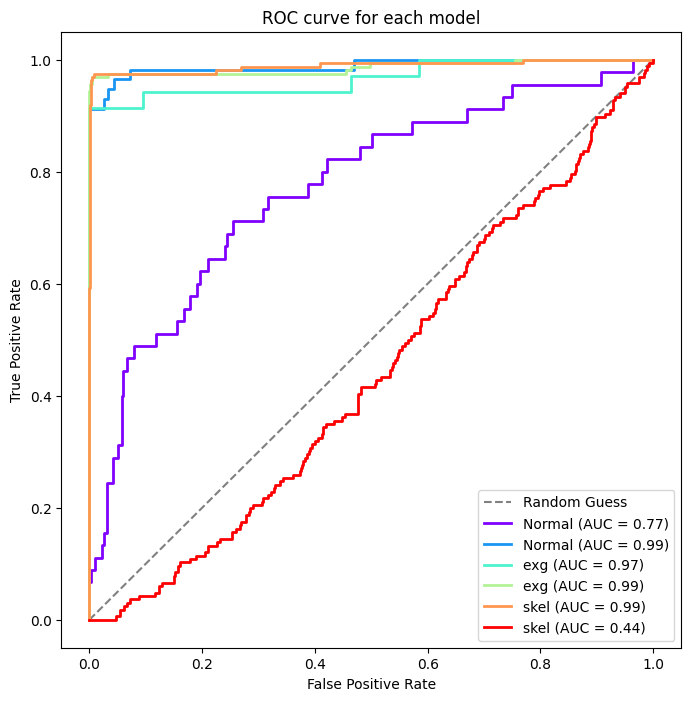

In [34]:
mod_list = [(model,test), (model_exg, test_exg), (model_skl, test_skel),
            (model_augmented, test_augmented), (model_exg_augmented, test_exg_augmented),
            (model_skl_augmented,test_skel_augmented)]

y_score = []
y_test = []

y_score_augmented = []
y_test_augmented = []

y_exg_score = []
y_exg_test = []

y_exg_score_augmented = []
y_exg_test_augmented =[]

y_skel_score = []
y_skel_test = []

y_skel_score_augmented = []
y_skel_test_augmented =[]

features = [[y_score, y_test],[y_exg_score, y_exg_test], [y_skel_score, y_skel_test],
            [y_score_augmented, y_test_augmented], [y_exg_score_augmented, y_exg_test_augmented],
            [y_skel_score_augmented, y_skel_test_augmented]]

for i in range(len(mod_list)):
    model = mod_list[i][0]
    model.eval()

    data = mod_list[i][1]

    with torch.no_grad():
        for inputs, labels in data:
            outputs = model(inputs)
            features[i][0].append(outputs.numpy())
            features[i][1].append(labels.numpy())

    features[i][0] = np.concatenate(features[i][0])
    features[i][1] = np.concatenate(features[i][1])

fprs, tprs, aucs = [], [], []
for x in range(len(features)):
    fpr, tpr, _ = roc_curve(features[x][1], features[x][0][:, 1])
    roc_auc = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
colors = plt.cm.rainbow(np.linspace(0, 1, len(fprs)))

for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], color=colors[i], lw=2,
             label='{} (AUC = {:.2f})'.format(['Normal','exg', 'skel','NORMAL','EXG', 'SKEL'][i // 2], aucs[i]))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for each model')
plt.legend(loc="lower right")
plt.show()

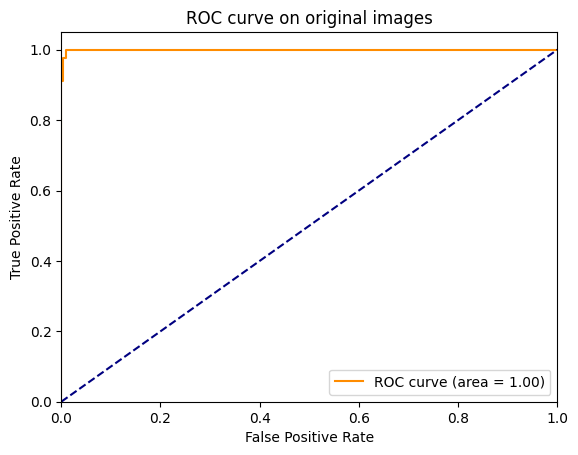

In [35]:
model_path = '/work/1677187833_normal.pt'
#Call the model
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()

y_score = []
y_test = []

with torch.no_grad():
    for inputs, labels in test:
        outputs = model(inputs)
        y_score.append(outputs.numpy())
        y_test.append(labels.numpy())

y_score = np.concatenate(y_score)
y_test = np.concatenate(y_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on original images')
plt.legend(loc="lower right")
plt.show()

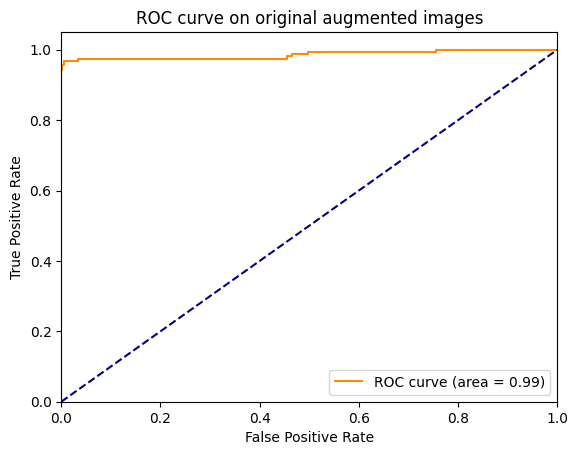

In [36]:
model_path = '/work/FINAL_data_augmented/Models/1677208706_data_augmented.pt'
#Call the model
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()

y_score = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_augmented:
        outputs = model(inputs)
        y_score.append(outputs.numpy())
        y_test.append(labels.numpy())

y_score = np.concatenate(y_score)
y_test = np.concatenate(y_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on original augmented images')
plt.legend(loc="lower right")
plt.show()

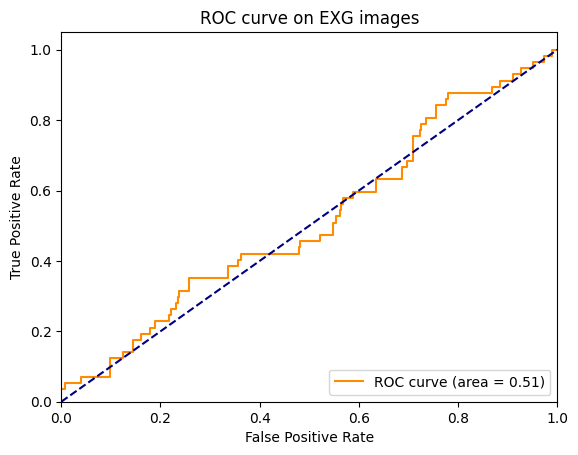

In [37]:
model_path = '/work/1678756956_EXG.pt'
#Call the model
model_exg = models.resnet18()
num_ftrs = model_exg.fc.in_features
model_exg.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_exg.load_state_dict(state_dict)
model.eval()

y_score = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_exg:
        outputs = model(inputs)
        y_score.append(outputs.numpy())
        y_test.append(labels.numpy())

y_score = np.concatenate(y_score)
y_test = np.concatenate(y_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on EXG images')
plt.legend(loc="lower right")
plt.show()

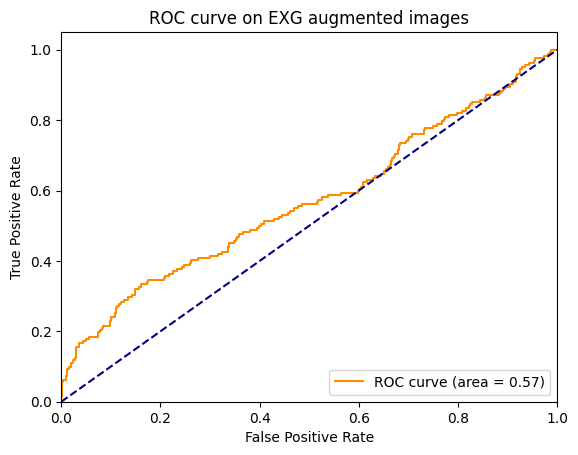

In [38]:
model_path = '/work/FINAL_data_augmented/Models/1677198755_data_exg_augmented.pt'
#Call the model
model_exg_augmented = models.resnet18()
num_ftrs = model_exg_augmented.fc.in_features
model_exg_augmented.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_exg_augmented.load_state_dict(state_dict)
model.eval()

y_score = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_exg_augmented:
        outputs = model(inputs)
        y_score.append(outputs.numpy())
        y_test.append(labels.numpy())

y_score = np.concatenate(y_score)
y_test = np.concatenate(y_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on EXG augmented images')
plt.legend(loc="lower right")
plt.show()

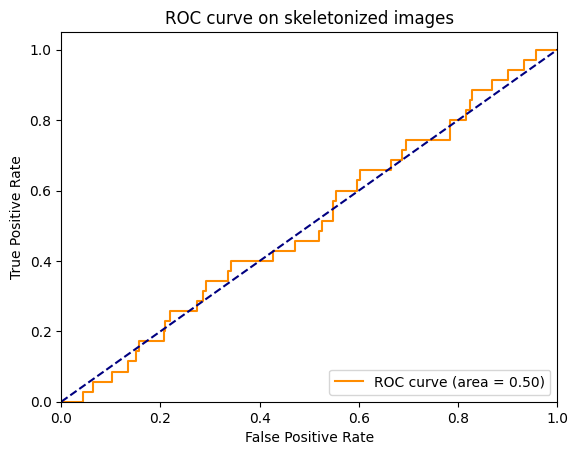

In [19]:
model_path = '/work/Models_history/Downloads1678718625_skel.pt'
#Call the model
model_skl = models.resnet18()
num_ftrs = model_skl.fc.in_features
model_skl.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_skl.load_state_dict(state_dict)
model.eval()

y_score = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_skel:
        outputs = model(inputs)
        y_score.append(outputs.numpy())
        y_test.append(labels.numpy())

y_score = np.concatenate(y_score)
y_test = np.concatenate(y_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on skeletonized images')
plt.legend(loc="lower right")
plt.show()

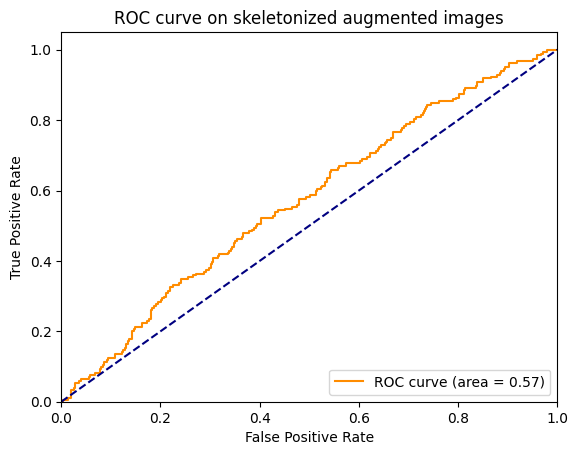

In [20]:
model_path = '/work/FINAL_data_augmented/Models/1677216599_data_skel_augmented.pt'
#Call the model
model_skl_augmented = models.resnet18()
num_ftrs = model_skl_augmented.fc.in_features
model_skl_augmented.fc = nn.Linear(num_ftrs, 2)
state_dict = torch.load(model_path)
model_skl_augmented.load_state_dict(state_dict)
model.eval()

y_score = []
y_test = []

with torch.no_grad():
    for inputs, labels in test_skel_augmented:
        outputs = model(inputs)
        y_score.append(outputs.numpy())
        y_test.append(labels.numpy())

y_score = np.concatenate(y_score)
y_test = np.concatenate(y_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on skeletonized augmented images')
plt.legend(loc="lower right")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f211ba4-8439-4b4f-a72d-48759d094385' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>